In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def read_roc(dir_path: str):
    roc = {}
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        roc[target] = np.load(os.path.join(dir_path, 'ROC_{}.npy'.format(target)), allow_pickle=True)
    return roc

control_roc = read_roc('../output/control')
KNN_roc = read_roc('../output/data_fill/KNN')
rpca_roc = read_roc('../output/data_fill/rpca')

In [3]:
def lineplot(data, x=None, y=None, hue=None, xticklabels=None, output_path: str = None, figsize: tuple = (24, 12)):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.lineplot(data=data, x=x, y=y, hue=hue)
    ax = sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='red')

    plt.legend(loc='lower right')
    plt.grid(False)

    if x:
        plt.xlabel(x)
    if y:
        plt.ylabel(y)
    if xticklabels:
        ax.set_xticklabels(labels=xticklabels)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()

In [4]:
def plot(roc, output_dir=None):
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        methods_result = roc[target].item()

        _rocs = pd.DataFrame()
        for method_name in methods_result.keys():
            _xs, _ys = methods_result[method_name][0], methods_result[method_name][1]

            tprs = []
            mean_fpr = np.linspace(0, 1, 100)
            for i in range(len(_xs)):
                _x, _y = _xs[i], _ys[i]
                interp_tpr = np.interp(mean_fpr, _x, _y)
                interp_tpr[0], interp_tpr[-1] = 0.0, 1
                _tprs = interp_tpr.tolist()
                tprs.extend(_tprs)

            _df = pd.DataFrame({
                'FPR': mean_fpr.tolist() * len(_xs), 'TPR': tprs,
                'method': '{}(AUC={})'.format(method_name, round(np.mean(methods_result[method_name][2]), 2))
            })
            _rocs = pd.concat([_rocs, _df])
        _rocs.reset_index(drop=True, inplace=True)

        lineplot(
            _rocs,
            x='FPR',
            y='TPR',
            hue='method',
            output_path='{}/ROC({}).pdf'.format(output_dir, target) if output_dir else None,
            figsize=(8, 8)
        )

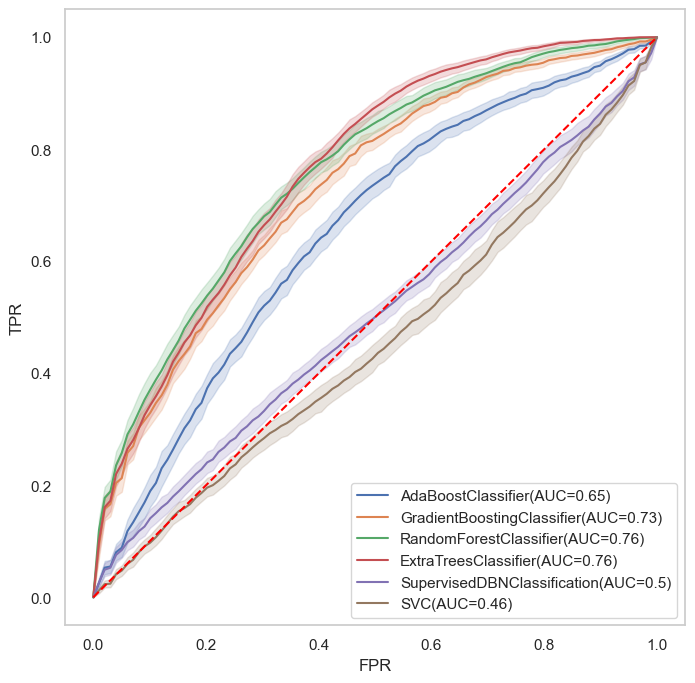

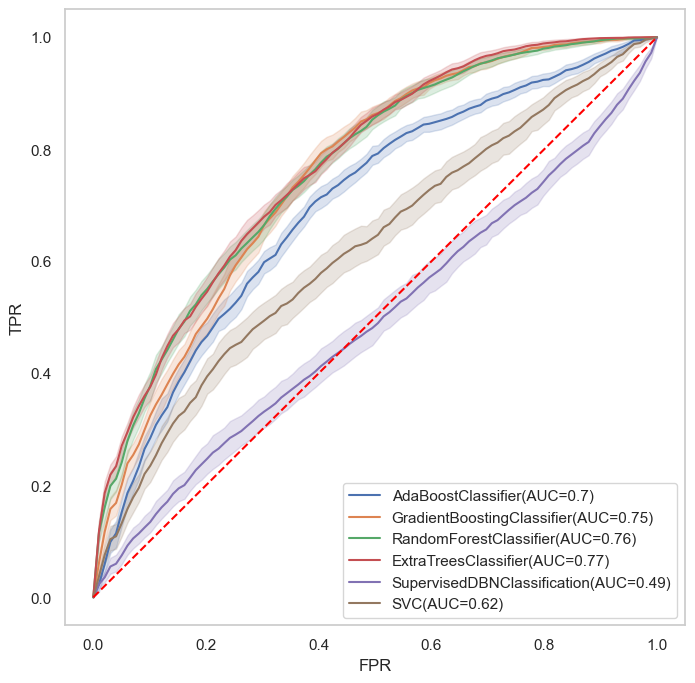

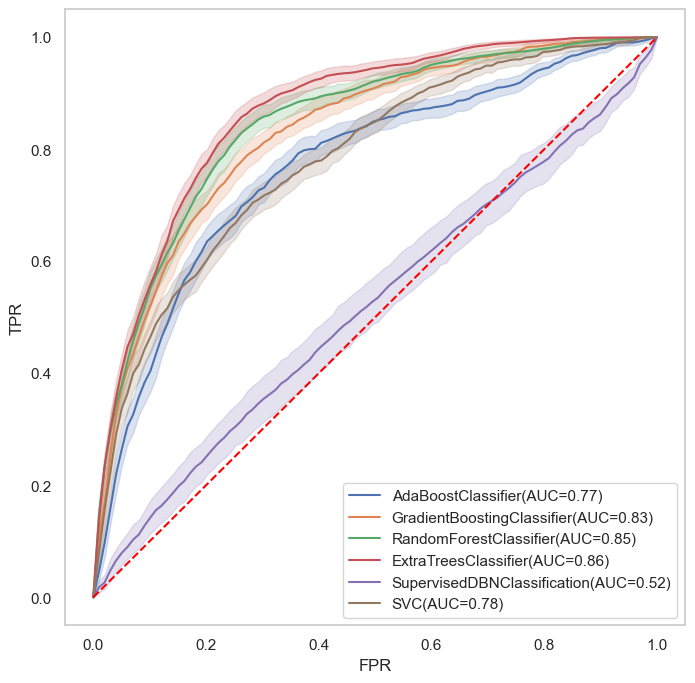

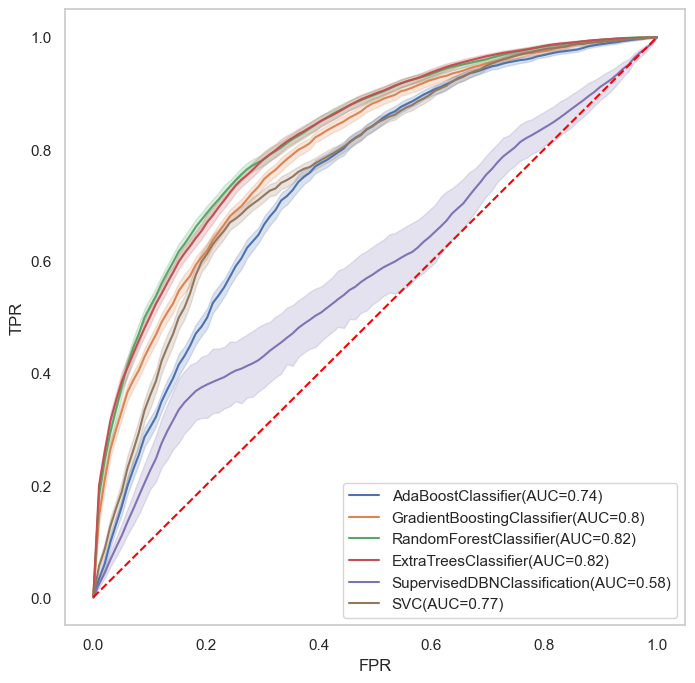

In [5]:
plot(control_roc, '../output/control')

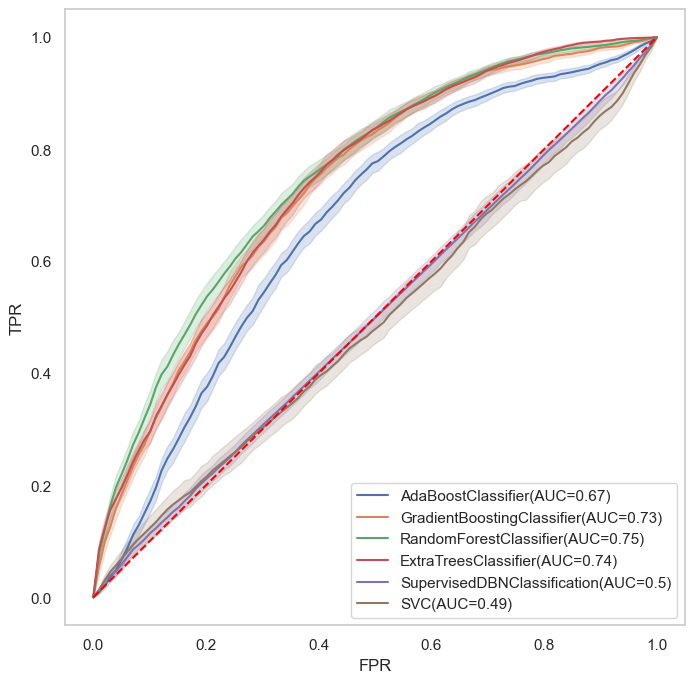

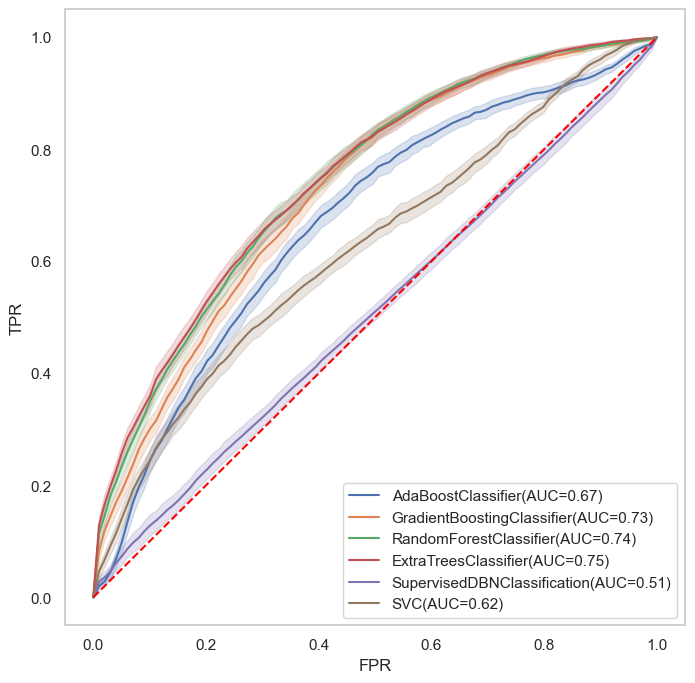

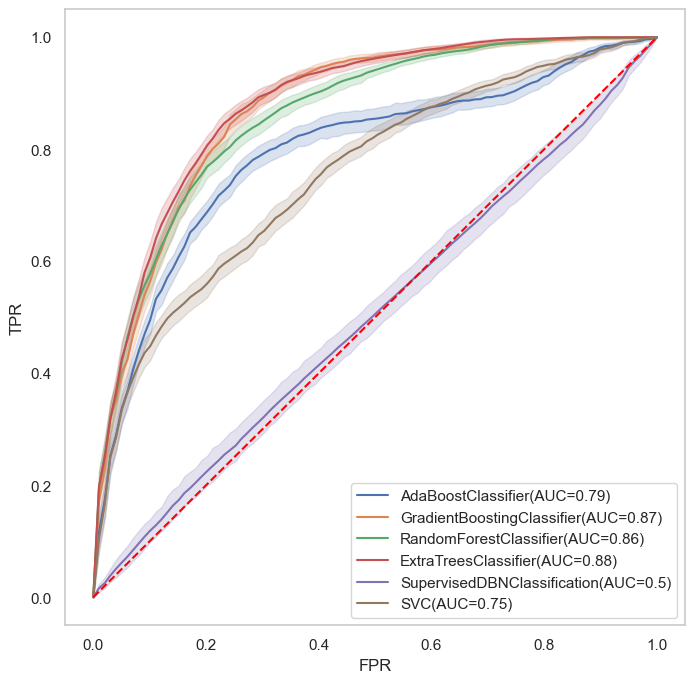

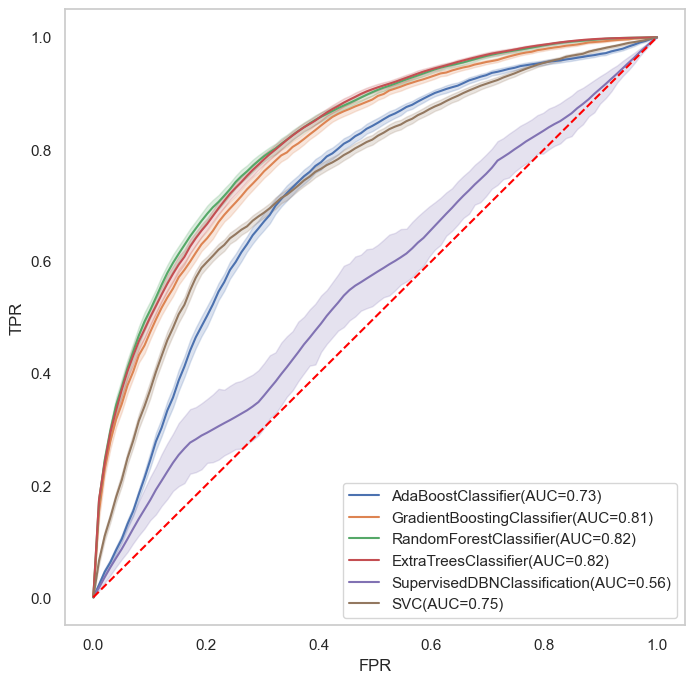

In [6]:
plot(KNN_roc, '../output/data_fill/KNN')

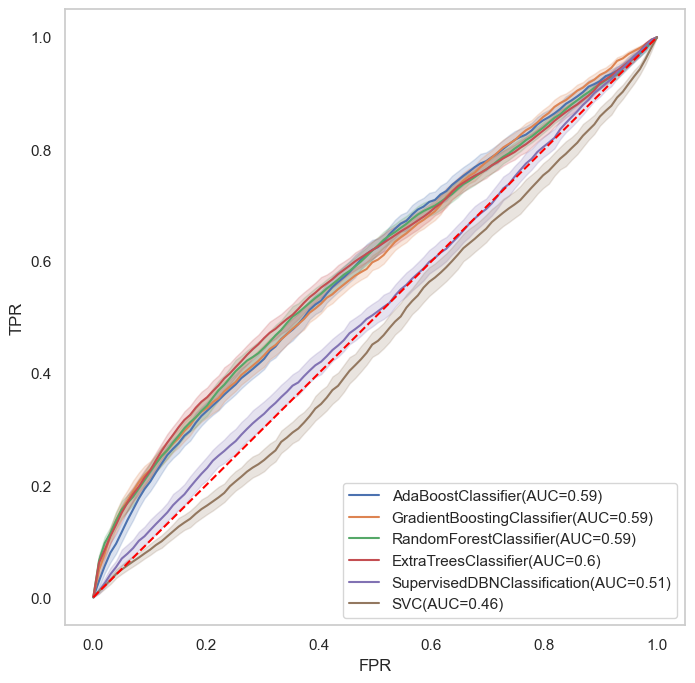

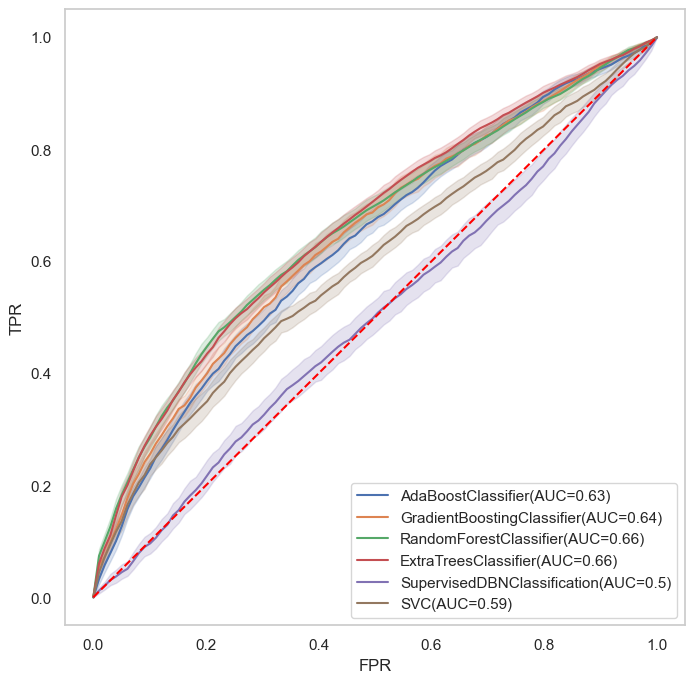

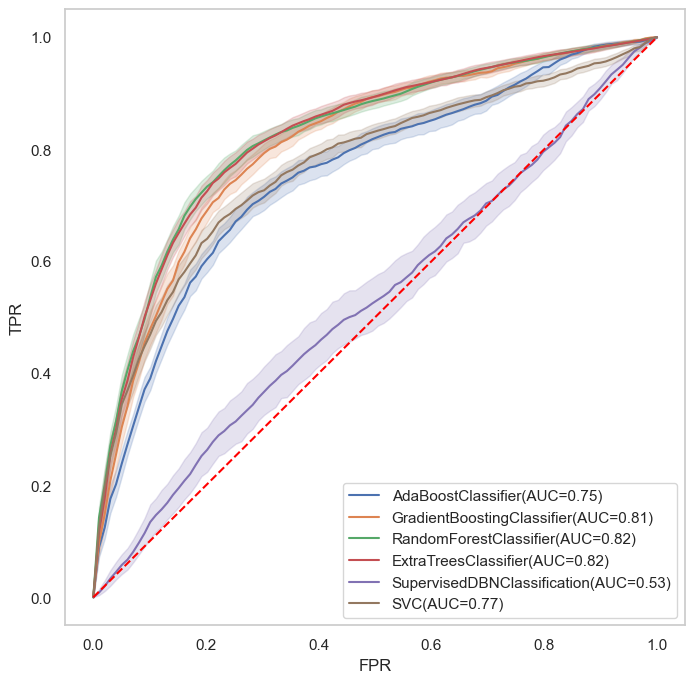

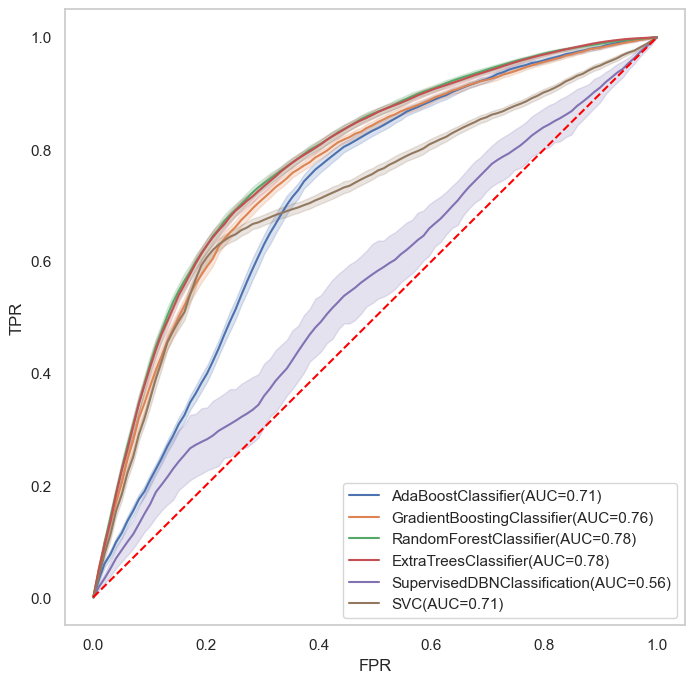

In [7]:
plot(rpca_roc, '../output/data_fill/rpca')

In [8]:
def read_accuracy(dir_path: str):
    acc = {}
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        acc[target] = pd.read_csv(os.path.join(dir_path, 'accuracy_{}.csv'.format(target)), index_col=0)
    return acc

control_acc = read_accuracy('../output/control')
KNN_acc = read_accuracy('../output/data_fill/KNN')
rpca_acc = read_accuracy('../output/data_fill/rpca')

In [9]:
def get_comprehensive_comparison(acc, roc):
    acc_result = pd.DataFrame()
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        _acc = pd.DataFrame(acc[target].mean(), columns=[target])
        _acc = (round(_acc * 100, 2)).astype(str)
        _acc[target] += '±' + (round(acc[target].std() * 100, 2)).astype(str)
        acc_result = pd.concat([acc_result, _acc], axis=1)
    acc_result.columns = pd.MultiIndex.from_product([['Accuracy(%)'], acc_result.columns])

    roc_auc_result = pd.DataFrame()
    for target in ['effective', 'markedly effective', 'cured', 'all']:
        _roc = roc[target].item()
        _roc_auc = [
            roc[target].item()[key][2]
            for key in _roc.keys()
        ]
        _roc_auc = pd.DataFrame(_roc_auc, index=_roc.keys())
        _auc = pd.DataFrame(_roc_auc.mean(axis=1), columns=[target])
        _auc = (round(_auc, 2)).astype(str)
        _auc[target] += '±' + (round(_roc_auc.std(axis=1), 2)).astype(str)
        roc_auc_result = pd.concat([roc_auc_result, _auc], axis=1)
    roc_auc_result.columns = pd.MultiIndex.from_product([['ROC-AUC'], roc_auc_result.columns])

    comprehensive_result = pd.concat([acc_result, roc_auc_result], axis=1)
    return comprehensive_result

In [10]:
comprehensive_result = get_comprehensive_comparison(control_acc, control_roc)
comprehensive_result.to_csv('../output/control/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                 \
                              effective markedly effective       cured   
AdaBoostClassifier           61.84±4.26         67.16±3.85  77.27±3.68   
GradientBoostingClassifier   66.51±3.23         69.18±3.47  80.53±3.53   
RandomForestClassifier       68.73±3.67         71.13±3.69  81.24±2.95   
ExtraTreesClassifier         68.53±3.46         71.09±3.41  81.76±2.68   
SupervisedDBNClassification  46.67±2.59         64.16±3.53  76.45±3.46   
SVC                          47.95±4.93         64.16±3.53  76.45±3.46   

                                           ROC-AUC                     \
                                    all  effective markedly effective   
AdaBoostClassifier           48.78±4.85  0.65±0.05           0.7±0.04   
GradientBoostingClassifier   53.95±3.96  0.73±0.03          0.75±0.04   
RandomForestClassifier       58.76±3.73  0.76±0.04          0.76±0.04   
ExtraTreesClassifier         56.98±4.04  0.76±0.03          0.77±0.03   
SupervisedDBNClassification  50.09±4.25   0.5±0.05          0.49±0.08   
SVC                          50.09±4.25  0.46±0.05          0.62±0.08   

                                                   
                                 cured        all  
AdaBoostClassifier           0.77±0.05  0.74±0.03  
GradientBoostingClassifier   0.83±0.04   0.8±0.02  
RandomForestClassifier       0.85±0.04  0.82±0.02  
ExtraTreesClassifier         0.86±0.03  0.82±0.02  
SupervisedDBNClassification   0.52±0.1  0.58±0.13  
SVC                          0.78±0.05  0.77±0.03

In [11]:
comprehensive_result = get_comprehensive_comparison(KNN_acc, KNN_roc)
comprehensive_result.to_csv('../output/data_fill/KNN/comprehensive_comparison.csv')
comprehensive_result

Accuracy(%)                                 \
                              effective markedly effective       cured   
AdaBoostClassifier            63.7±3.57         65.62±3.08  81.58±2.38   
GradientBoostingClassifier   67.07±3.49         68.03±3.12   83.19±2.6   
RandomForestClassifier        67.75±3.9         69.83±3.02  83.28±2.69   
ExtraTreesClassifier         67.14±3.33         69.98±2.96   83.7±2.51   
SupervisedDBNClassification  48.69±2.52         63.56±2.56  78.81±2.36   
SVC                          51.19±3.57         63.56±2.56  78.81±2.36   

                                           ROC-AUC                     \
                                    all  effective markedly effective   
AdaBoostClassifier           49.39±4.78  0.67±0.04          0.67±0.04   
GradientBoostingClassifier    55.58±3.1  0.73±0.04          0.73±0.03   
RandomForestClassifier       58.24±3.54  0.75±0.04          0.74±0.03   
ExtraTreesClassifier         56.97±3.45  0.74±0.04          0.75±0.03   
SupervisedDBNClassification   50.51±2.8   0.5±0.04          0.51±0.05   
SVC                           50.51±2.8  0.49±0.08          0.62±0.04   

                                                   
                                 cured        all  
AdaBoostClassifier           0.79±0.05  0.73±0.02  
GradientBoostingClassifier   0.87±0.03  0.81±0.02  
RandomForestClassifier       0.86±0.03  0.82±0.02  
ExtraTreesClassifier         0.88±0.03  0.82±0.02  
SupervisedDBNClassification   0.5±0.08  0.56±0.12  
SVC                          0.75±0.04  0.75±0.02